In [1]:
import os
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
from surprise import SVD
from surprise import KNNBasic
from surprise import CoClustering
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from multiprocessing import Pool

In [2]:
movies = pd.read_csv('data/10m/movies.dat', sep="::", usecols = [0, 2], names = ['movieId', 'genres'])
ratings = pd.read_csv('data/10m/ratings.dat', sep="::", usecols = [0, 1, 2], names = ['userId', 'movieId', 'rating'])

/home/caym/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/caym/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [3]:
genres_list = []
for i in movies['genres']:
    genres_list.extend(i.split('|'))
genres = list(set(genres_list))
genres

['Action',
 'Film-Noir',
 'War',
 'Western',
 'Fantasy',
 'Crime',
 'Animation',
 'Thriller',
 'Mystery',
 'IMAX',
 'Romance',
 'Adventure',
 '(no genres listed)',
 'Sci-Fi',
 'Musical',
 'Drama',
 'Children',
 'Documentary',
 'Comedy',
 'Horror']

In [4]:
dict_mov = Counter(genres_list)
val_mov = np.array(list(dict_mov.values()))
val_mov = val_mov / val_mov.sum()
movie_distr = dict(zip(list(dict_mov.keys()), val_mov))

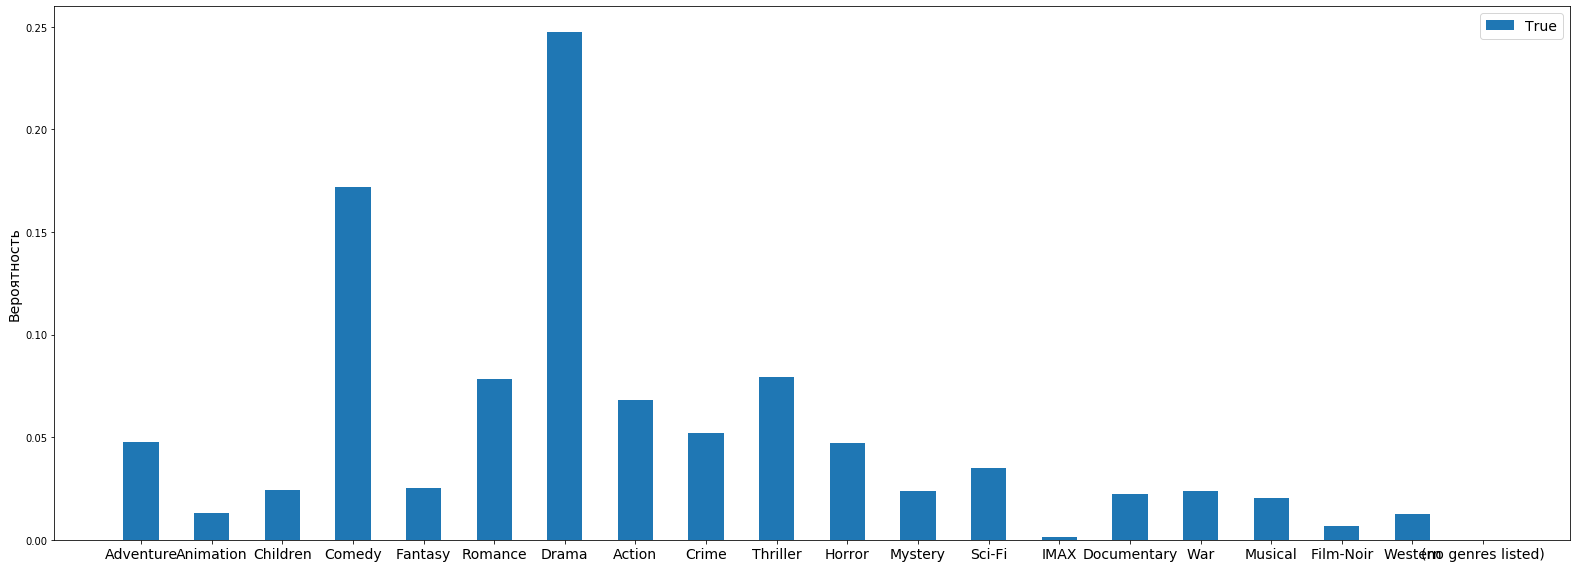

In [5]:
x = np.arange(len(genres))
width = 0.5

fig, ax = plt.subplots(figsize=(22,8))
rects1 = ax.bar(x, movie_distr.values(), width, label='True')

ax.set_ylabel('Вероятность', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(movie_distr.keys(), fontsize=14)
ax.legend(fontsize=14)
fig.tight_layout()

plt.show()

In [6]:
col_df = ['userId']
col_df.extend(genres)

In [7]:
users = list(set(ratings['userId']))

In [ ]:
reader = Reader(line_format='user item rating')

In [ ]:
data = Dataset.load_from_df(ratings, reader=reader)

In [12]:
# data = Dataset.load_builtin('ml-20m')

In [12]:
algo = KNNBasic()

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True, n_jobs=4)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [18]:
trainset, testset = train_test_split(data, test_size=.3)

In [9]:
df = shuffle(ratings)
trainset = df[:3500000].reset_index().drop(['index'], axis=1)
testset = df[3500000:].reset_index().drop(['index'], axis=1)

In [ ]:
reader = Reader(rating_scale=(0, 5.0))

data = Dataset.load_from_df(trainset[['userId', 'movieId', 'rating']], reader)

In [ ]:
train = data.build_full_trainset()
test = testset.values

In [ ]:
algo = NormalPredictor()

algo.fit(train)
predictions = algo.test(test)

In [46]:
predictions = pd.read_csv('data/predictions.csv')

In [47]:
usersId = predictions['uid'].values
usersId = list(set(usersId))
pred = pd.DataFrame(predictions)

In [48]:
trainset.to_csv('data/trainset.csv', index=None)

In [49]:
trainset = pd.read_csv('data/trainset.csv')

In [50]:
rec = pred.loc[pred['est']>=3.5]

In [51]:
dist = trainset.loc[trainset['rating'] >= 3.5] #pred.loc[pred['r_ui']>3.5]

In [52]:
rec

,uid,iid,r_ui,est
0,7411.0,3105.0,5.0,3.793993
1,822.0,266.0,3.0,5.000000
3,20085.0,26150.0,4.0,4.020540
9,12253.0,1968.0,4.0,4.545552
12,27584.0,4978.0,3.5,3.642281
...,...,...,...,...
1508047,6587.0,348.0,3.0,4.558962
1508048,33805.0,4993.0,4.5,5.000000
1508051,19958.0,4370.0,3.5,3.837130
1508052,18828.0,1721.0,3.0,4.008581


In [53]:
dist

,userId,movieId,rating
1,19287,3105,4.0
2,24930,7022,4.0
3,10759,33815,3.5
4,16557,3733,4.0
5,27964,6548,3.5
...,...,...,...
3499988,25136,1682,5.0
3499989,29996,2436,4.0
3499990,9877,26782,3.5
3499997,10593,480,5.0


In [54]:
rec['iid'].values

array([ 3105.,   266., 26150., ...,  4370.,  1721.,  1213.])

In [55]:
col_df

['userId',
 'Action',
 'Film-Noir',
 'War',
 'Western',
 'Fantasy',
 'Crime',
 'Animation',
 'Thriller',
 'Mystery',
 'IMAX',
 'Romance',
 'Adventure',
 '(no genres listed)',
 'Sci-Fi',
 'Musical',
 'Drama',
 'Children',
 'Documentary',
 'Comedy',
 'Horror']

In [56]:
us = [21 * [0]] * len(usersId)
t_us = [21 * [0]] * len(set(dist['userId']))
t_dist = pd.DataFrame(data=t_us, columns=col_df)
p_dist = pd.DataFrame(data=us, columns=col_df)

In [57]:
p_dist['userId'] = usersId
t_dist['userId'] = list(set(dist['userId'].values))

In [58]:
gen_df_rec = pd.DataFrame(data=[[0]*20], columns=genres)
gen_df_true = pd.DataFrame(data=[[0]*20], columns=genres)

In [59]:
gen_df_rec = {x: 0 for x in genres}

In [60]:
for i in tqdm(rec['iid'].values):
    gen = movies.loc[movies['movieId']==int(i), 'genres'].values[0].split('|')
    for k in gen:
        gen_df_rec[k] += 1

In [61]:
gen_df_true = {x: 0 for x in genres}

In [62]:
for i in tqdm(dist['movieId'].values):
    gen = movies.loc[movies['movieId']==int(i), 'genres'].values[0].split('|')
    for k in gen:
        gen_df_true[k] += 1

In [63]:
dist_rec = np.array(list(gen_df_rec.values())) / sum(list(gen_df_rec.values()))

In [64]:
gen_df_rec

{'Action': 214910,
 'Film-Noir': 10256,
 'War': 43085,
 'Western': 15945,
 'Fantasy': 77292,
 'Crime': 112247,
 'Animation': 38865,
 'Thriller': 196163,
 'Mystery': 47887,
 'IMAX': 655,
 'Romance': 144487,
 'Adventure': 159421,
 '(no genres listed)': 2,
 'Sci-Fi': 111693,
 'Musical': 36224,
 'Drama': 331144,
 'Children': 61665,
 'Documentary': 7871,
 'Comedy': 296270,
 'Horror': 57951}

In [65]:
gen_df_true

{'Action': 543331,
 'Film-Noir': 36884,
 'War': 137916,
 'Western': 43740,
 'Fantasy': 209808,
 'Crime': 337414,
 'Animation': 113611,
 'Thriller': 527333,
 'Mystery': 146542,
 'IMAX': 2275,
 'Romance': 396778,
 'Adventure': 427478,
 '(no genres listed)': 0,
 'Sci-Fi': 279378,
 'Musical': 101225,
 'Drama': 996757,
 'Children': 155990,
 'Documentary': 26798,
 'Comedy': 765403,
 'Horror': 134464}

In [66]:
dist_rec

array([1.09422805e-01, 5.22190819e-03, 2.19370041e-02, 8.11849903e-03,
       3.93537176e-02, 5.71512800e-02, 1.97883640e-02, 9.98776497e-02,
       2.43819732e-02, 3.33497451e-04, 7.35664828e-02, 8.11702247e-02,
       1.01831283e-06, 5.68692074e-02, 1.84436820e-02, 1.68604092e-01,
       3.13971303e-02, 4.00757014e-03, 1.50847771e-01, 2.95061234e-02])

In [67]:
dist_true = np.array(list(gen_df_true.values())) / sum(list(gen_df_true.values()))

In [68]:
dist_true

array([0.10093227, 0.00685178, 0.02562006, 0.00812539, 0.03897513,
       0.06267995, 0.02110503, 0.09796039, 0.02722248, 0.00042262,
       0.07370774, 0.07941075, 0.        , 0.05189885, 0.01880413,
       0.18516326, 0.02897759, 0.00497815, 0.14218563, 0.0249788 ])

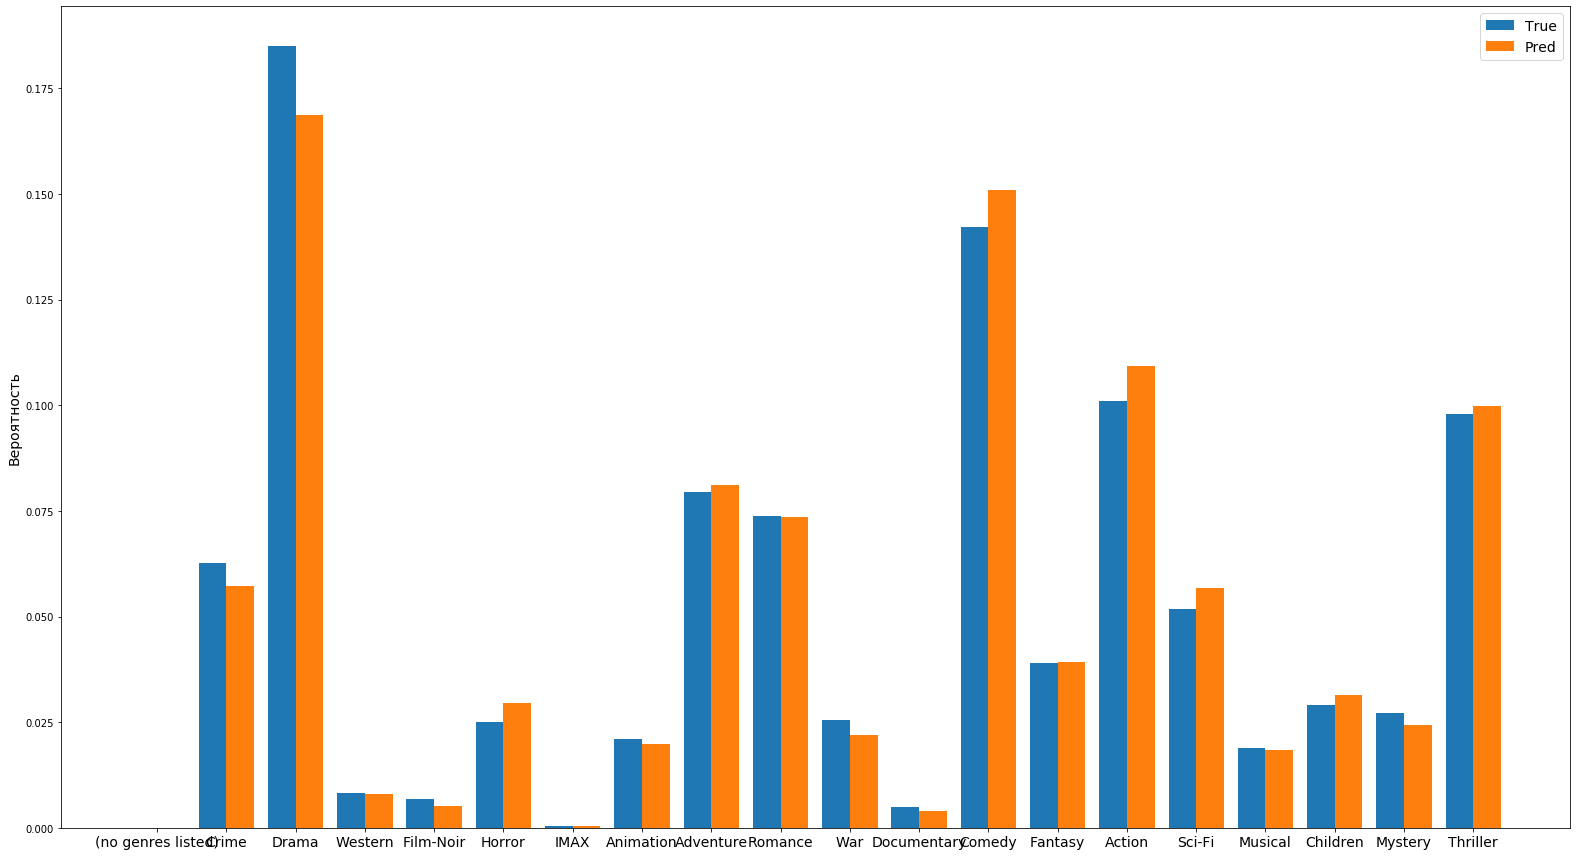

In [37]:
x = np.arange(len(gen_df_true))
width = 0.4

fig, ax = plt.subplots(figsize=(22,12))
rects1 = ax.bar(x-width/2, dist_true, width, label='True')
rects1 = ax.bar(x+width/2, dist_rec, width, label='Pred')


ax.set_ylabel('Вероятность', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(gen_df_true.keys(), fontsize=14)
ax.legend(fontsize=14)
fig.tight_layout()

plt.show()

In [70]:
predictions = pd.read_csv('data/predictions.csv')

In [38]:
predictions = pd.DataFrame(predictions)
predictions.drop(['details'], inplace=True, axis=1)

KeyError: "['details'] not found in axis"

In [37]:
pd.DataFrame(predictions).to_csv('data/predictions.csv', index=None)

In [104]:
predictions

,uid,iid,r_ui,est
0,5,163,5.0,5.000000
1,2,2997,2.0,4.686335
2,4,3081,4.0,2.341934
3,3,3489,3.5,4.787312
4,3,1961,3.0,3.378632
...,...,...,...,...
1252009,3,4344,3.5,3.254104
1252010,4,1912,4.0,3.682014
1252011,5,1333,5.0,2.762485
1252012,3,1333,3.0,4.658041


In [39]:
rat_train = trainset.loc[trainset['rating'] > 3.5]

In [40]:
trainUsersId = list(set(rat_train['userId'].values))

In [41]:
trainMovieId = list(set(trainset['movieId'].values))

In [42]:
us = [21 * [0]] * len(trainUsersId)
train_dist = pd.DataFrame(data=us, columns=col_df)
train_dist['userId'] = trainUsersId

In [43]:
for i in tqdm(trainUsersId):
    movId = trainset.loc[trainset['userId']==i, 'movieId'].values
    for j in movId:
        gen = movies.loc[movies['movieId']==j, 'genres'].values
        if gen.size == 0:
            continue
        gen = gen[0].split('|')
        for k in gen:
            train_dist.loc[train_dist['userId']==i, k] += 1

KeyboardInterrupt: 

In [44]:
tr_dist = []
def user_genre_dist(i):
    temp = [i]
    gen_col = dict(zip(genres, len(genres) * [0]))
    movId = trainset.loc[trainset['userId']==i, 'movieId'].values
    for j in movId:
        gen = movies.loc[movies['movieId']==j, 'genres'].values
        if gen.size == 0:
            continue
        gen = gen[0].split('|')
        for k in gen:
            gen_col[k] += 1
    temp.extend(list(gen_col.values()))
    return temp
        
    
with Pool(7) as p:
    tr_dist = p.map(user_genre_dist, trainUsersId)

In [45]:
train_dist = pd.DataFrame(data=tr_dist, columns=col_df)

In [46]:
train_dist

,userId,(no genres listed),Crime,Drama,Western,Film-Noir,Horror,IMAX,Animation,Adventure,...,War,Documentary,Comedy,Fantasy,Action,Sci-Fi,Musical,Children,Mystery,Thriller
0,1,0,1,6,0,0,0,0,4,6,...,2,0,10,2,9,5,3,7,0,4
1,2,0,1,4,0,0,1,0,0,7,...,3,0,2,1,11,6,1,1,0,4
2,3,0,1,14,2,1,0,0,0,2,...,5,0,6,2,5,0,1,0,1,3
3,4,0,4,10,1,0,1,0,1,9,...,3,0,10,4,13,7,1,2,0,9
4,5,0,9,48,0,1,4,0,1,7,...,5,0,25,4,5,7,4,4,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34875,35796,0,1,17,0,1,1,0,4,7,...,2,0,23,7,1,1,4,9,1,1
34876,35797,0,36,76,3,13,6,0,3,12,...,9,0,49,10,19,10,3,6,10,49
34877,35798,0,44,148,4,2,57,1,15,110,...,20,3,149,56,134,83,9,29,22,116
34878,35799,0,17,51,2,0,3,0,7,33,...,8,1,27,15,35,14,7,11,6,17


In [47]:
predictions

,uid,iid,r_ui,est
0,7411.0,3105.0,5.0,3.793993
1,822.0,266.0,3.0,5.000000
2,3350.0,3676.0,2.0,2.537664
3,20085.0,26150.0,4.0,4.020540
4,18763.0,32587.0,3.0,2.674762
...,...,...,...,...
1508050,13473.0,51857.0,2.5,2.683957
1508051,19958.0,4370.0,3.5,3.837130
1508052,18828.0,1721.0,3.0,4.008581
1508053,28155.0,1213.0,4.0,4.454989


In [48]:
rat_pred = predictions.loc[predictions['est'] > 3.5]
predUsersId = list(set(rat_pred['uid'].values))

In [49]:
pr_dist = []
def user_genre_dist(i):
    temp = [i]
    gen_col = dict(zip(genres, len(genres) * [0]))
    movId = predictions.loc[predictions['uid']==i, 'iid'].values
    for j in movId:
        gen = movies.loc[movies['movieId']==j, 'genres'].values
        if gen.size == 0:
            continue
        gen = gen[0].split('|')
        for k in gen:
            gen_col[k] += 1
    temp.extend(list(gen_col.values()))
    return temp
        
    
with Pool(7) as p:
    pr_dist = p.map(user_genre_dist, predUsersId)

In [50]:
pred_dist = pd.DataFrame(data=pr_dist, columns=col_df)

In [51]:
pred_dist

,userId,(no genres listed),Crime,Drama,Western,Film-Noir,Horror,IMAX,Animation,Adventure,...,War,Documentary,Comedy,Fantasy,Action,Sci-Fi,Musical,Children,Mystery,Thriller
0,1.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
1,2.0,0,0,3,1,0,0,0,0,3,...,0,0,2,0,3,0,0,0,1,3
2,3.0,0,2,6,1,0,0,0,2,4,...,1,0,5,1,2,0,0,2,3,3
3,4.0,0,1,4,2,0,0,0,2,4,...,0,0,9,1,4,1,2,3,0,2
4,5.0,0,2,16,0,0,2,0,0,1,...,1,0,4,0,0,1,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34770,35796.0,0,1,8,0,0,0,0,2,6,...,0,1,5,3,4,2,3,6,0,1
34771,35797.0,0,17,27,1,1,4,0,1,3,...,3,0,28,0,12,3,1,1,5,22
34772,35798.0,0,18,61,0,0,13,1,13,56,...,9,2,62,24,67,35,7,25,11,45
34773,35799.0,0,7,26,2,1,1,0,3,15,...,6,0,22,8,13,6,3,7,3,7


In [52]:
temp = []

In [53]:
for i in pred_dist[genres].values:
    temp.append(i/sum(i))

In [54]:
pred_dist[genres] = temp
pred_dist

,userId,(no genres listed),Crime,Drama,Western,Film-Noir,Horror,IMAX,Animation,Adventure,...,War,Documentary,Comedy,Fantasy,Action,Sci-Fi,Musical,Children,Mystery,Thriller
0,1.0,0.0,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000
1,2.0,0.0,0.000000,0.166667,0.055556,0.000000,0.000000,0.000000,0.000000,0.166667,...,0.000000,0.000000,0.111111,0.000000,0.166667,0.000000,0.000000,0.000000,0.055556,0.166667
2,3.0,0.0,0.055556,0.166667,0.027778,0.000000,0.000000,0.000000,0.055556,0.111111,...,0.027778,0.000000,0.138889,0.027778,0.055556,0.000000,0.000000,0.055556,0.083333,0.083333
3,4.0,0.0,0.025641,0.102564,0.051282,0.000000,0.000000,0.000000,0.051282,0.102564,...,0.000000,0.000000,0.230769,0.025641,0.102564,0.025641,0.051282,0.076923,0.000000,0.051282
4,5.0,0.0,0.055556,0.444444,0.000000,0.000000,0.055556,0.000000,0.000000,0.027778,...,0.027778,0.000000,0.111111,0.000000,0.000000,0.027778,0.000000,0.000000,0.027778,0.055556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34770,35796.0,0.0,0.022727,0.181818,0.000000,0.000000,0.000000,0.000000,0.045455,0.136364,...,0.000000,0.022727,0.113636,0.068182,0.090909,0.045455,0.068182,0.136364,0.000000,0.022727
34771,35797.0,0.0,0.123188,0.195652,0.007246,0.007246,0.028986,0.000000,0.007246,0.021739,...,0.021739,0.000000,0.202899,0.000000,0.086957,0.021739,0.007246,0.007246,0.036232,0.159420
34772,35798.0,0.0,0.038136,0.129237,0.000000,0.000000,0.027542,0.002119,0.027542,0.118644,...,0.019068,0.004237,0.131356,0.050847,0.141949,0.074153,0.014831,0.052966,0.023305,0.095339
34773,35799.0,0.0,0.047619,0.176871,0.013605,0.006803,0.006803,0.000000,0.020408,0.102041,...,0.040816,0.000000,0.149660,0.054422,0.088435,0.040816,0.020408,0.047619,0.020408,0.047619


In [55]:
temp = []

In [56]:
for i in train_dist[genres].values:
    temp.append(i/sum(i))

In [57]:
train_dist[genres] = temp
train_dist

,userId,(no genres listed),Crime,Drama,Western,Film-Noir,Horror,IMAX,Animation,Adventure,...,War,Documentary,Comedy,Fantasy,Action,Sci-Fi,Musical,Children,Mystery,Thriller
0,1,0.0,0.015625,0.093750,0.000000,0.000000,0.000000,0.000000,0.062500,0.093750,...,0.031250,0.000000,0.156250,0.031250,0.140625,0.078125,0.046875,0.109375,0.000000,0.062500
1,2,0.0,0.022727,0.090909,0.000000,0.000000,0.022727,0.000000,0.000000,0.159091,...,0.068182,0.000000,0.045455,0.022727,0.250000,0.136364,0.022727,0.022727,0.000000,0.090909
2,3,0.0,0.019608,0.274510,0.039216,0.019608,0.000000,0.000000,0.000000,0.039216,...,0.098039,0.000000,0.117647,0.039216,0.098039,0.000000,0.019608,0.000000,0.019608,0.058824
3,4,0.0,0.050633,0.126582,0.012658,0.000000,0.012658,0.000000,0.012658,0.113924,...,0.037975,0.000000,0.126582,0.050633,0.164557,0.088608,0.012658,0.025316,0.000000,0.113924
4,5,0.0,0.056604,0.301887,0.000000,0.006289,0.025157,0.000000,0.006289,0.044025,...,0.031447,0.000000,0.157233,0.025157,0.031447,0.044025,0.025157,0.025157,0.018868,0.075472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34875,35796,0.0,0.011236,0.191011,0.000000,0.011236,0.011236,0.000000,0.044944,0.078652,...,0.022472,0.000000,0.258427,0.078652,0.011236,0.011236,0.044944,0.101124,0.011236,0.011236
34876,35797,0.0,0.107463,0.226866,0.008955,0.038806,0.017910,0.000000,0.008955,0.035821,...,0.026866,0.000000,0.146269,0.029851,0.056716,0.029851,0.008955,0.017910,0.029851,0.146269
34877,35798,0.0,0.040854,0.137419,0.003714,0.001857,0.052925,0.000929,0.013928,0.102136,...,0.018570,0.002786,0.138347,0.051996,0.124420,0.077066,0.008357,0.026927,0.020427,0.107707
34878,35799,0.0,0.062500,0.187500,0.007353,0.000000,0.011029,0.000000,0.025735,0.121324,...,0.029412,0.003676,0.099265,0.055147,0.128676,0.051471,0.025735,0.040441,0.022059,0.062500


In [58]:
train_dist.to_csv('data/train_dist.csv', index=None)
pred_dist.to_csv('data/pred_dist.csv', index=None)

In [69]:
train_dist = pd.read_csv('data/train_dist.csv')
pred_dist = pd.read_csv('data/pred_dist.csv')

In [195]:
cal = []
lambd = 0.5
alpha = 0.001
def CL_div(i):
    genr = movies.loc[movies['movieId']==int(i[1]), 'genres'].values[0].split('|')
    CL = 0
    for g in genr:
        p = train_dist.loc[train_dist['userId']==int(i[0]), g].values
        if p.size == 0:
            p = 0
        else:
            p = p[0]
        q = pred_dist.loc[pred_dist['userId']==int(i[0]), g].values
        if q.size == 0:
            q = 0
        else:
            q = q[0]
        q = (1-alpha)*q+alpha*p
        if np.isnan(p) or int(p)==0:
            CL = q
            continue
        CL += p*log(p/q)
    return abs(1.0*i[3]-lambd*CL), CL

with Pool(7) as po:
    cal = po.map(CL_div, tqdm(predictions.values))

In [70]:
cal = []
lambd = 0.5
alpha = 0.001
def CL_div(i):
    genr = movies.loc[movies['movieId']==int(i[1]), 'genres'].values[0].split('|')
    g = genr[0]
    p = train_dist.loc[train_dist['userId']==int(i[0]), g].values
    if p.size == 0:
        p = 0
    else:
        p = p[0]
    q = pred_dist.loc[pred_dist['userId']==int(i[0]), g].values
    if q.size == 0:
        q = 0
    else:
        q = q[0]
    q = (1-alpha)*q+alpha*p
    if np.isnan(p) or int(p)==0:
        CL = q
    else:
        CL = p*log(p/q)
    return abs((0.7)*i[3]+2.5*CL), CL

with Pool(7) as po:
    cal = po.map(CL_div, tqdm(predictions.values))

In [88]:
CL = []
y_cal = []
for i in cal:
    CL.append(i[1])
    y_cal.append(i[0])

In [89]:
with open('data/CL0.7,2.5.txt', 'w') as f:
    for item in CL:
        f.write(str(item) + '\n')

In [90]:
with open('data/y_cal0.7,2.5.txt', 'w') as f:
    for item in y_cal:
        f.write(str(item) + '\n')

In [91]:
with open('data/y_cal0.7,2.5.txt') as f:
    lines = f.read().splitlines()

In [92]:
y_cal = []
for i in lines:
    y_cal.append(float(i))

In [93]:
np.array(CL).mean()

0.14042933167711802

In [94]:
y_pred = predictions['est'].values
y_true = predictions['r_ui'].values

In [95]:
mse(y_true, y_pred), mse(y_true, y_cal)

(2.1021757610185614, 2.153778940438092)

In [96]:
mse(y_true, y_pred, squared=False), mse(y_true, y_cal, squared=False)

(1.4498881891437565, 1.467575872123173)

In [97]:
predictions['cal'] = y_cal

In [98]:
predictions

,uid,iid,r_ui,est,cal
0,7411.0,3105.0,5.0,3.793993,3.009119
1,822.0,266.0,3.0,5.000000,4.203998
2,3350.0,3676.0,2.0,2.537664,2.248201
3,20085.0,26150.0,4.0,4.020540,3.412181
4,18763.0,32587.0,3.0,2.674762,2.051060
...,...,...,...,...,...
1508050,13473.0,51857.0,2.5,2.683957,2.478068
1508051,19958.0,4370.0,3.5,3.837130,2.978611
1508052,18828.0,1721.0,3.0,4.008581,3.154907
1508053,28155.0,1213.0,4.0,4.454989,3.321872


In [99]:
rat_cal = predictions.loc[predictions['cal'] > 3.5]
calUsersId = list(set(rat_cal['uid'].values))

In [100]:
cal_dist = []
def user_genre_dist(i):
    temp = [i]
    gen_col = dict(zip(genres, len(genres) * [0]))
    movId = predictions.loc[predictions['uid']==i, 'iid'].values
    for j in movId:
        gen = movies.loc[movies['movieId']==j, 'genres'].values
        if gen.size == 0:
            continue
        gen = gen[0].split('|')
        for k in gen:
            gen_col[k] += 1
    temp.extend(list(gen_col.values()))
    return temp
        
    
with Pool(7) as p:
    cal_dist = p.map(user_genre_dist, calUsersId)

In [101]:
cal_dist = pd.DataFrame(data=cal_dist, columns=col_df)

In [102]:
cal_dist

,userId,Action,Film-Noir,War,Western,Fantasy,Crime,Animation,Thriller,Mystery,...,Romance,Adventure,(no genres listed),Sci-Fi,Musical,Drama,Children,Documentary,Comedy,Horror
0,3.0,2,0,1,1,1,2,2,3,3,...,4,4,0,0,0,6,2,0,5,0
1,4.0,4,0,0,2,1,1,2,2,0,...,4,4,0,1,2,4,3,0,9,0
2,5.0,0,0,1,0,0,2,0,2,1,...,6,1,0,1,0,16,0,0,4,2
3,6.0,5,0,2,1,1,0,1,0,0,...,0,2,0,3,0,2,0,0,2,0
4,7.0,6,8,1,3,0,6,0,12,5,...,4,8,0,5,2,11,1,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32609,35796.0,4,0,0,0,3,1,2,1,0,...,2,6,0,2,3,8,6,1,5,0
32610,35797.0,12,1,3,1,0,17,1,22,5,...,9,3,0,3,1,27,1,0,28,4
32611,35798.0,67,0,9,0,24,18,13,45,11,...,23,56,0,35,7,61,25,2,62,13
32612,35799.0,13,1,6,2,8,7,3,7,3,...,17,15,0,6,3,26,7,0,22,1


In [103]:
temp = []

In [104]:
for i in cal_dist[genres].values:
    temp.append(i/sum(i))

In [105]:
cal_dist[genres] = temp
cal_dist

,userId,Action,Film-Noir,War,Western,Fantasy,Crime,Animation,Thriller,Mystery,...,Romance,Adventure,(no genres listed),Sci-Fi,Musical,Drama,Children,Documentary,Comedy,Horror
0,3.0,0.055556,0.000000,0.027778,0.027778,0.027778,0.055556,0.055556,0.083333,0.083333,...,0.111111,0.111111,0.0,0.000000,0.000000,0.166667,0.055556,0.000000,0.138889,0.000000
1,4.0,0.102564,0.000000,0.000000,0.051282,0.025641,0.025641,0.051282,0.051282,0.000000,...,0.102564,0.102564,0.0,0.025641,0.051282,0.102564,0.076923,0.000000,0.230769,0.000000
2,5.0,0.000000,0.000000,0.027778,0.000000,0.000000,0.055556,0.000000,0.055556,0.027778,...,0.166667,0.027778,0.0,0.027778,0.000000,0.444444,0.000000,0.000000,0.111111,0.055556
3,6.0,0.263158,0.000000,0.105263,0.052632,0.052632,0.000000,0.052632,0.000000,0.000000,...,0.000000,0.105263,0.0,0.157895,0.000000,0.105263,0.000000,0.000000,0.105263,0.000000
4,7.0,0.075949,0.101266,0.012658,0.037975,0.000000,0.075949,0.000000,0.151899,0.063291,...,0.050633,0.101266,0.0,0.063291,0.025316,0.139241,0.012658,0.000000,0.075949,0.012658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32609,35796.0,0.090909,0.000000,0.000000,0.000000,0.068182,0.022727,0.045455,0.022727,0.000000,...,0.045455,0.136364,0.0,0.045455,0.068182,0.181818,0.136364,0.022727,0.113636,0.000000
32610,35797.0,0.086957,0.007246,0.021739,0.007246,0.000000,0.123188,0.007246,0.159420,0.036232,...,0.065217,0.021739,0.0,0.021739,0.007246,0.195652,0.007246,0.000000,0.202899,0.028986
32611,35798.0,0.141949,0.000000,0.019068,0.000000,0.050847,0.038136,0.027542,0.095339,0.023305,...,0.048729,0.118644,0.0,0.074153,0.014831,0.129237,0.052966,0.004237,0.131356,0.027542
32612,35799.0,0.088435,0.006803,0.040816,0.013605,0.054422,0.047619,0.020408,0.047619,0.020408,...,0.115646,0.102041,0.0,0.040816,0.020408,0.176871,0.047619,0.000000,0.149660,0.006803


In [ ]:
cal = []
alpha = 0.001
def CL_div(i):
    genr = movies.loc[movies['movieId']==int(i[1]), 'genres'].values[0].split('|')
    CL = 0
    for g in genr:
        p = train_dist.loc[train_dist['userId']==int(i[0]), g].values
        if p.size == 0:
            p = 0
        else:
            p = p[0]
        q = cal_dist.loc[cal_dist['userId']==int(i[0]), g].values
        if q.size == 0:
            q = 0
        else:
            q = q[0]
        if np.isnan(p):
            CL = q
            continue
        CL += (sqrt(p)-sqrt(q))**2
    return 1/sqrt(2)*sqrt(CL)

with Pool(7) as po:
    CL = po.map(CL_div, predictions.values)

In [530]:
cal = []
lambd = 0.5
alpha = 0.001
def CL_div(i):
    genr = movies.loc[movies['movieId']==int(i[1]), 'genres'].values[0].split('|')
    g = genr[0]
    p = train_dist.loc[train_dist['userId']==int(i[0]), g].values
    if p.size == 0:
        p = 0
    else:
        p = p[0]
    q = cal_dist.loc[cal_dist['userId']==int(i[0]), g].values
    if q.size == 0:
        q = 0
    else:
        q = q[0]
    q = (1-alpha)*q+alpha*p
    if np.isnan(p) or int(p)==0:
        CL = q
    else:
        CL = p*log(p/q)
    return CL

with Pool(7) as po:
    cal = po.map(CL_div, tqdm(predictions.values))

In [106]:
np.array(cal).mean()

1.459365388865795

In [107]:
us = [21 * [0]] * len(calUsersId)
c_dist = pd.DataFrame(data=us, columns=col_df)

In [108]:
c_dist['userId'] = calUsersId

In [109]:
gen_df_cal = pd.DataFrame(data=[[0]*20], columns=genres)

In [110]:
gen_df_cal = {x: 0 for x in genres}

In [111]:
for i in tqdm(rat_cal['iid'].values):
    gen = movies.loc[movies['movieId']==int(i), 'genres'].values[0].split('|')
    for k in gen:
        gen_df_cal[k] += 1

In [112]:
dist_cal = np.array(list(gen_df_cal.values())) / sum(list(gen_df_cal.values()))

In [113]:
predictions

,uid,iid,r_ui,est,cal
0,7411.0,3105.0,5.0,3.793993,3.009119
1,822.0,266.0,3.0,5.000000,4.203998
2,3350.0,3676.0,2.0,2.537664,2.248201
3,20085.0,26150.0,4.0,4.020540,3.412181
4,18763.0,32587.0,3.0,2.674762,2.051060
...,...,...,...,...,...
1508050,13473.0,51857.0,2.5,2.683957,2.478068
1508051,19958.0,4370.0,3.5,3.837130,2.978611
1508052,18828.0,1721.0,3.0,4.008581,3.154907
1508053,28155.0,1213.0,4.0,4.454989,3.321872


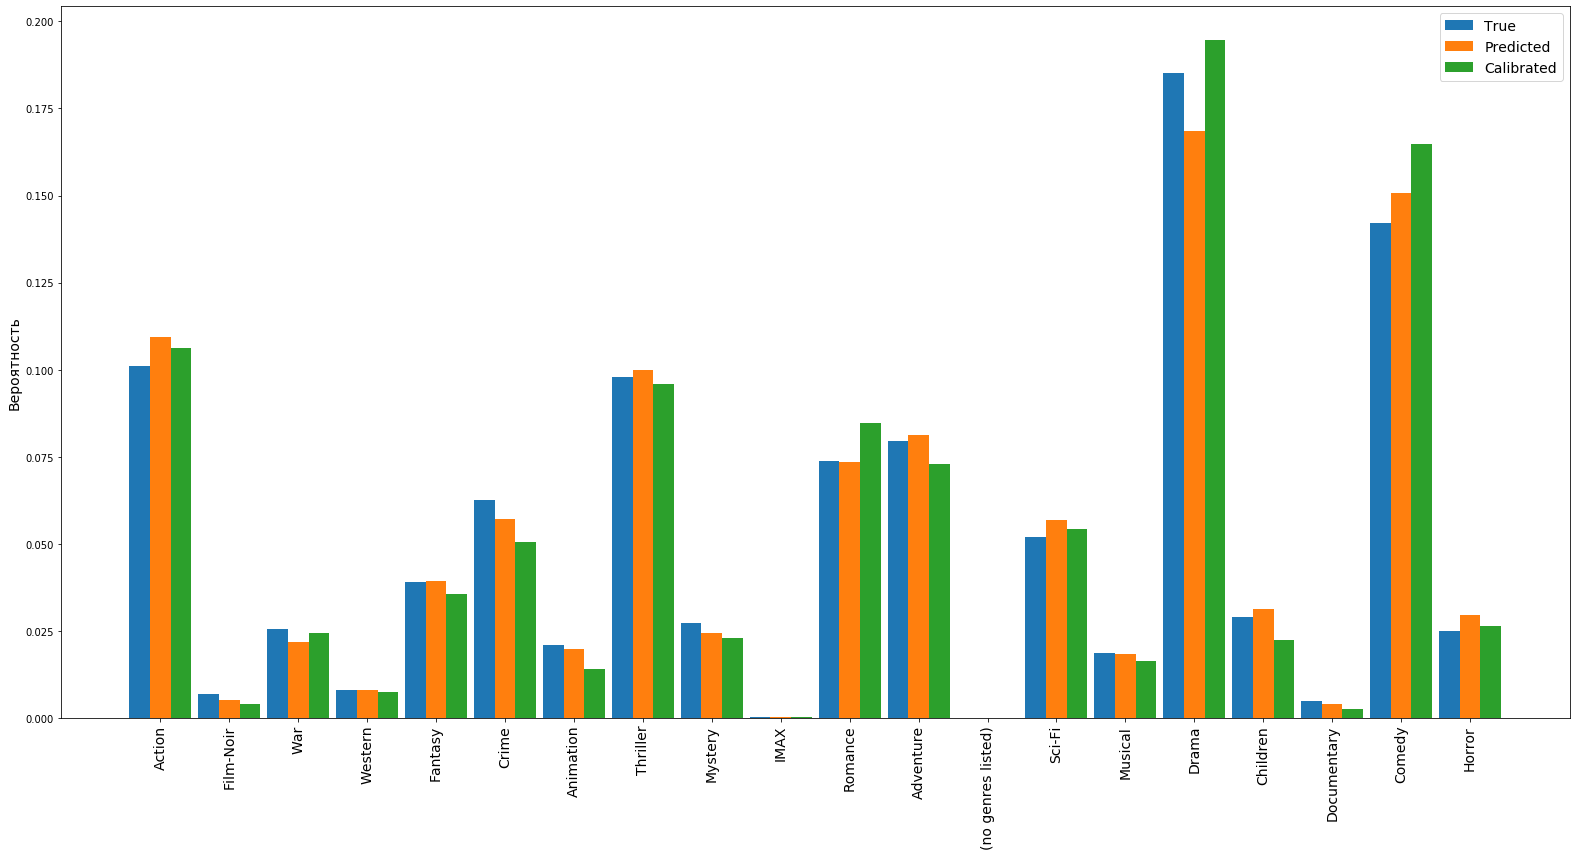

In [114]:
x = np.arange(len(genres))
width = 0.3

fig, ax = plt.subplots(figsize=(22,12))
rects1 = ax.bar(x - 3*width/3, dist_true, width, label='True')
rects2 = ax.bar(x, dist_rec, width, label='Predicted')
rects3 = ax.bar(x + 3*width/3, dist_cal, width, label='Calibrated')

ax.set_ylabel('Вероятность', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(gen_df_true.keys(), fontsize=14, rotation=90)
ax.legend(fontsize=14)
fig.tight_layout()

plt.show()

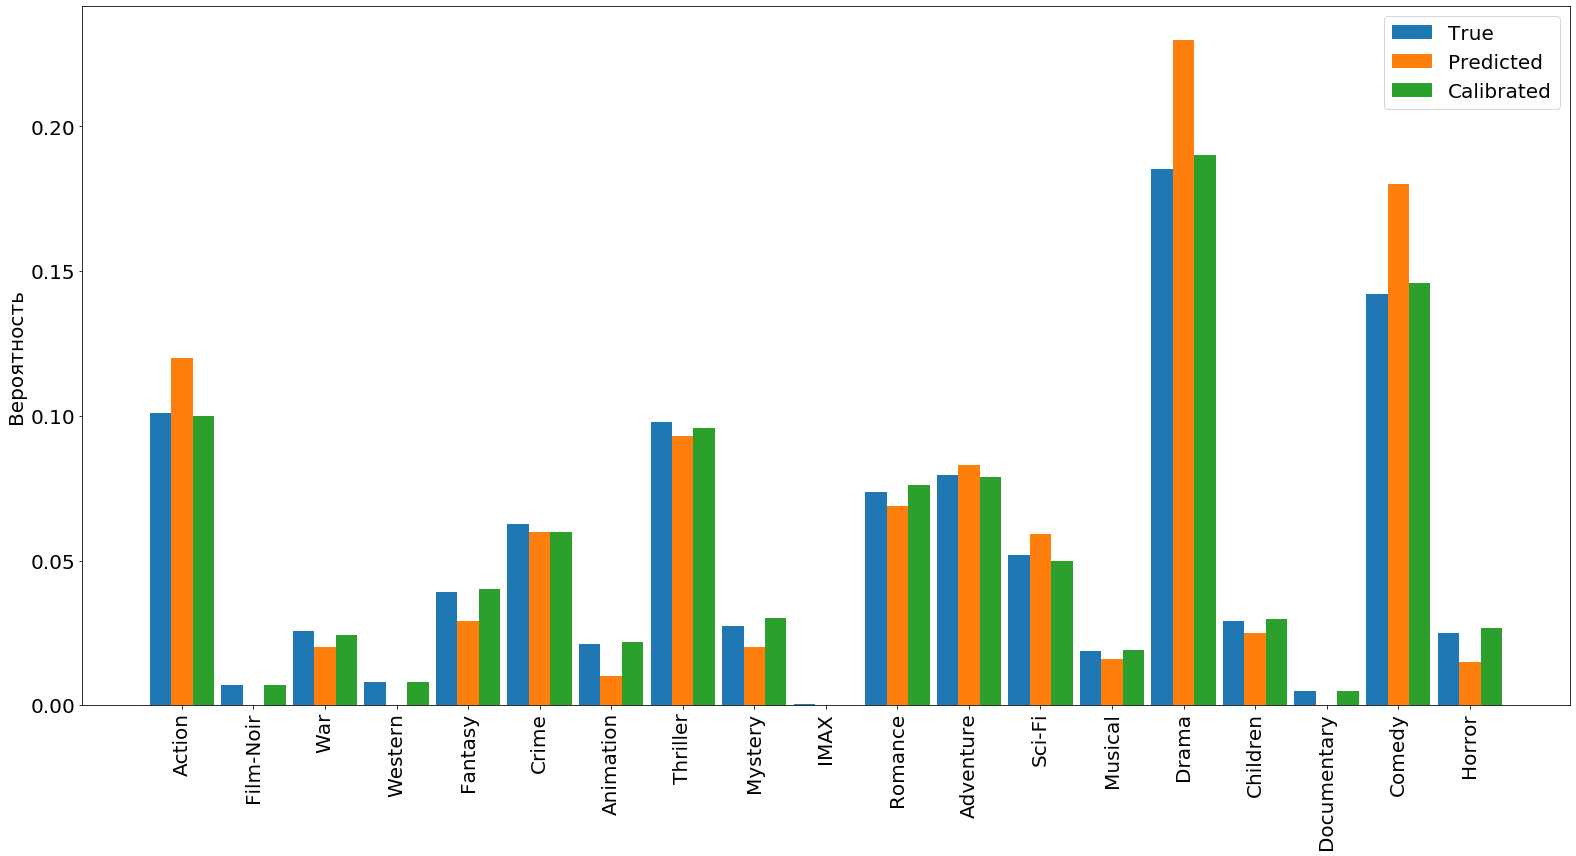

In [267]:
x = np.arange(len(genres))
width = 0.3

fig, ax = plt.subplots(figsize=(22,12))
rects1 = ax.bar(x - 3*width/3, dist_true, width, label='True')
rects2 = ax.bar(x, dist_rec, width, label='Predicted')
rects3 = ax.bar(x + 3*width/3, dist_cal, width, label='Calibrated')

ax.set_ylabel('Вероятность', fontsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_xticks(x)
ax.set_xticklabels(genres, fontsize=20, rotation=90)
ax.legend(fontsize=20)
fig.tight_layout()

plt.show()

In [ ]:
for i in tqdm(usersId):
    movId = rec.loc[rec['uid']==i, 'iid'].values
    for j in movId:
        gen = movies.loc[movies['movieId']==int(j), 'genre'].values[0].split('|')
        for k in gen:
            p_dist.loc[p_dist['userId']==i, k] += 1

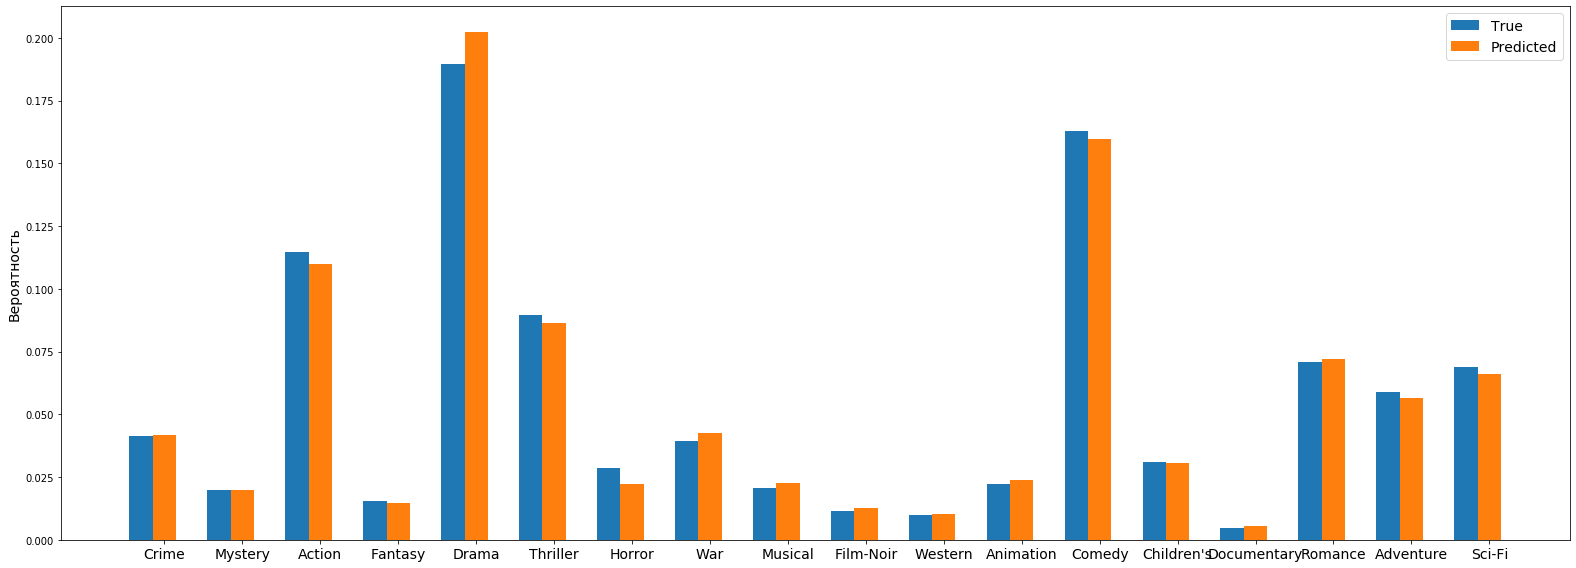

In [33]:
x = np.arange(len(genres))
width = 0.3

fig, ax = plt.subplots(figsize=(22,8))
rects1 = ax.bar(x - 3*width/3, dist_true, width, label='True')
rects2 = ax.bar(x, dist_rec, width, label='Predicted')
rects3 = ax.bar(x + 3*width/3, new_dist_true_gr, width, label='Calibrated')

ax.set_ylabel('Вероятность', fontsize=14)
ax.set_xticks(x, rotation=90)
ax.set_xticklabels(genres, fontsize=14)
ax.legend(fontsize=14)
fig.tight_layout()

plt.show()

In [33]:
new_dist_true_gr = new_gen_df_true.iloc[0] / new_gen_df_true.iloc[0].sum()

AttributeError: 'dict' object has no attribute 'iloc'

In [8]:
predictions = pd.read_csv('data/predictions.csv')


In [9]:
predictions

,uid,iid,r_ui,est
0,7411.0,3105.0,5.0,3.793993
1,822.0,266.0,3.0,5.000000
2,3350.0,3676.0,2.0,2.537664
3,20085.0,26150.0,4.0,4.020540
4,18763.0,32587.0,3.0,2.674762
...,...,...,...,...
1508050,13473.0,51857.0,2.5,2.683957
1508051,19958.0,4370.0,3.5,3.837130
1508052,18828.0,1721.0,3.0,4.008581
1508053,28155.0,1213.0,4.0,4.454989


In [19]:
tp = 0
fp = 0
fn = 0
for i in predictions[['r_ui', 'est']].values:
    if i[0] >= 4 and i[1] >= 4:
        tp += 1
    elif i[0] < 4 and i[1] >= 4:
        fp += 1
    elif i[0] >=4 and i[1] < 4:
        fn += 1

In [20]:
prec = tp / (tp+fp)
rec = tp / (tp+fn)
prec, rec

(0.4971988129336463, 0.32042019349051937)